# Analyse financial data for regime clustering

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("talk")
import numpy as np

In [2]:
# non productive code, we ignore the non-sparse data below
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## View on fundamental financial data
Let's take two time series from publicly available data (retrieved from FRED, Federal Reserve Bank of St. Louis):  
* Take yearly inflation data: https://fred.stlouisfed.org/graph/?g=1cuWy  
* and take volatility data: https://fred.stlouisfed.org/graph/?g=1cuWW  

They are on different time scales, so we need a little transformation before:
* Inflation is until end of 2022  
* Volatility is longer and daily data 

In [3]:
#please download the data from the sources above, they're free to use
vix = pd.read_csv("./VIXCLS.csv", na_values=["."])
infl = pd.read_csv("./FPCPITOTLZGUSA.csv")

In [4]:
inflation = infl["FPCPITOTLZGUSA"].to_numpy() #we can directly take inflation data

In [5]:
vix.tail()

,DATE,VIXCLS
8848,2023-12-01,12.63
8849,2023-12-04,13.08
8850,2023-12-05,12.85
8851,2023-12-06,12.97
8852,2023-12-07,13.06


In [6]:
vix = vix.loc[vix.DATE < "2023-01-01"] # we want data only until end of 2022

In [7]:
vix.index = pd.to_datetime(vix.DATE)
volatility = vix["VIXCLS"].resample("BAS").max().to_numpy() #we take the maximum per business year

In [8]:
assert(volatility.shape == inflation.shape)
finance_data = np.vstack([volatility, inflation]).T #stack the two (same size!) arrays together for the scaler

In [9]:
MyScaler = StandardScaler()
finance_scaled = MyScaler.fit_transform(X=finance_data)

In [10]:
finance_scaled=pd.DataFrame(finance_scaled, columns=["vol", "infl"]) #re-transform to pandas DataFrame for nicer plotting

In [11]:
# now let's run k-means for a few values of k
inertias = []
for k in range(2,6):
    cluster = KMeans(n_clusters=k)
    predictions = cluster.fit_predict(X=finance_scaled)
    inertias.append(cluster.inertia_)
    finance_scaled["cluster_"+str(k)] = predictions

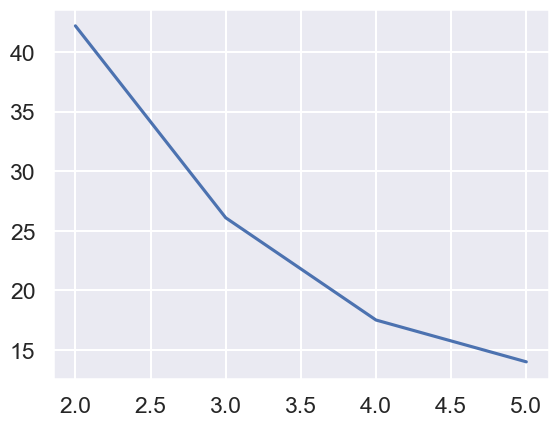

In [12]:
plt.plot(np.arange(2,6,1),inertias) # using elbow-heuristic to gain a good k
#plt.savefig("./choose_k.svg", bbox_inches="tight")

Although the kink at k=3 is a little more pronounced, I'd like to use four clusters for my financial regime

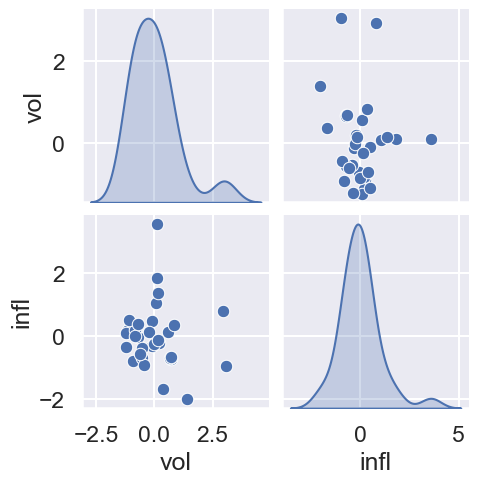

In [13]:
sns.pairplot(finance_scaled[["vol", "infl"]], diag_kind="kde") #in the plain data clusters are not easily spotted
#plt.savefig("./finance_covered.svg", bbox_inches="tight")

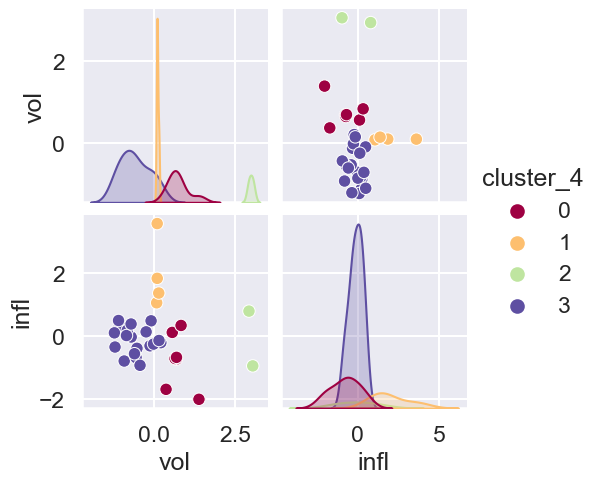

In [14]:
sns.pairplot(finance_scaled[["vol", "infl", "cluster_4"]], hue="cluster_4", palette="Spectral"); #however the four clusters found with k-means can be sensible
#plt.savefig("./finance_uncovered.svg", bbox_inches="tight")